In [ ]:
### Dependencies instantiation ###

# Only run this cell once, if you haven't run it yet
# This ensures that you have all the necessary dependencies installed

using Pkg
Pkg.activate("../")
Pkg.instantiate()

In [1]:
### Imports ###

include("../src/QuantumPrimer.jl")
using .QuantumPrimer
using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers

#### Examples: run one cell

In [2]:
using Combinatorics
using StatsBase

In [3]:
function get_sign_vecs(n::Int, n_part::Union{Int, Vector{Int}})
    isodd(n) ? n=n+1 : nothing
    typeof(n_part) == Int ? n_part = [n_part] : nothing
    maximum(n_part) > n/2 ? error("n_part must be less than n/2") : nothing
    div(n,2) in n_part ? n_states = sum(binomial.(n,setdiff(n_part,div(n,2)))) + div(binomial(n,div(n,2)),2) : n_states = sum(binomial.(n,n_part))
    #parts = filter(i -> any(ele -> length(ele) == n_part, i), collect(partitions(1:n, 2)))
    res = Vector{Vector{Int64}}(undef,n_states)
    for (ind,subset) in enumerate(powerset(collect(1:n), n_part[1],n_part[end]))
        # The complement of the subset is the other partition
        complement = setdiff(collect(1:n), subset)
        subset[1] == 1 ? part = [subset, complement] : part = [complement, subset]
        vec = ones(n)
        map(j -> vec[j] = -1, part[2])
        res[ind] = vec
        ind == n_states ? break : nothing        
    end
    return res
end

get_sign_vecs (generic function with 1 method)

In [4]:
N=16
n=Int(ceil(log2(N)))

4

In [5]:
all_vecs = get_sign_vecs(N,[6,7,8])
all_vecs2 = get_sign_vecs(N,[1,2,3])
for vec in all_vecs
    append!(vec, repeat([0], 2^n-N)) # pad candidate solutions with zeros (if n not a power of 2)
end
for vec in all_vecs2
    append!(vec, repeat([0], 2^n-N)) # pad candidate solutions with zeros (if n not a power of 2)
end

In [6]:
minimum([length(all_vecs),length(all_vecs2)])

696

In [7]:
n_states = minimum([length(all_vecs),length(all_vecs2)])

n_samples = 100

all_inds = sample(1:n_states, n_samples*2, replace = false)

tr_inds = all_inds[1:n_samples]
te_inds = setdiff(all_inds,tr_inds)

states1 = [ArrayReg(all_vecs[i]|>normalize.|>ComplexF64) for i in all_inds]
states2 = [ArrayReg(all_vecs2[i]|>normalize.|>ComplexF64) for i in all_inds]

tr_states = vcat([states1[1:n_samples],states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

te_states = vcat([states1[n_samples+1:2*n_samples],states2[n_samples+1:2*n_samples]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);


#### Model parameters

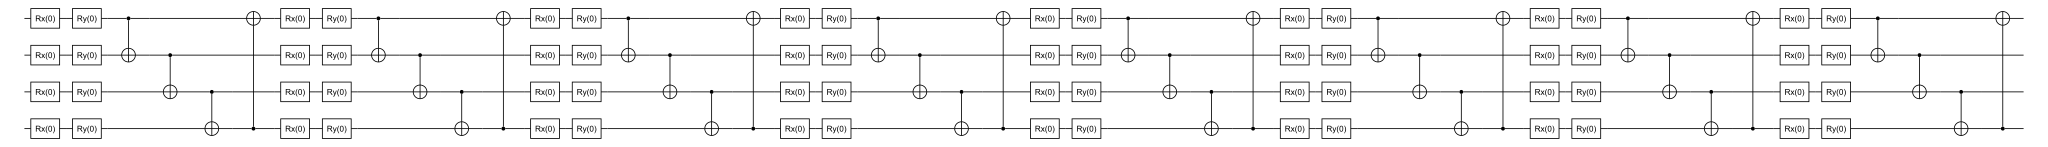

In [33]:
iters = 1000 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.

##### Cost #####
cost_fun = circ_Z
activation = x -> sigmoid(10x) # default is identity
cost = CircuitCost(cost_fun, activation)
################

##### QCNN #####
# ansatz = circ_SU4_conv # circ_Ry_conv, circ_Ry_simple_conv, circ_SU4_conv
# circ = build_QCNN(n, ansatz=ansatz)
################

##### QNN #####
ansatz = circ_HEA
#depth = ceil(Int, log2(n))
depth = 2n
circ = build_QNN(n, depth, ansatz=ansatz)
###############

##### Model #####
model = GeneralModel(n=n, circ=circ, ansatz=ansatz)
# model = InvariantModel(n=n, circ=circ, ansatz=ansatz) # only valid for QCNN
#################

initialize_params(model);
# model.params = 2pi * rand(nparameters(model.circ))

YaoPlots.plot(circ)
# YaoPlots.plot(cost(n))

#### Run

In [35]:
model_results = train_test_model(d1, d2, model, cost, iters, optim; regularization=:nothing, verbose=true);
#model_results = train_test_model(d1, d2, model, cost, iters, optim; lambda=1e-2, regularization=:l1, verbose=true);
# model_results = train_test_model(d1, d2, model, cost, iters, optim; lambda=6e-4, regularization=:l2, verbose=true);

params, loss_track, tr_track, te_track, tr_preds, te_preds = model_results;

Initial: loss = 1.4285448825584934, tr_acc = 0.52, te_acc = 0.495
Iteration 125: loss = 0.01356677449914456, tr_acc = 1.0, te_acc = 0.955
Iteration 250: loss = 0.012155240245574888, tr_acc = 1.0, te_acc = 0.955
Iteration 375: loss = 0.011493124173260212, tr_acc = 1.0, te_acc = 0.97
Iteration 500: loss = 0.010266601839231431, tr_acc = 1.0, te_acc = 0.96
Iteration 625: loss = 0.009902701815488489, tr_acc = 1.0, te_acc = 0.96
Iteration 750: loss = 0.009840633014095115, tr_acc = 1.0, te_acc = 0.96
Iteration 875: loss = 0.009793827527449022, tr_acc = 1.0, te_acc = 0.96
Iteration 1000: loss = 0.009482817893000314, tr_acc = 1.0, te_acc = 0.97
Final: loss = 0.009482817893000314, tr_acc = 1.0, te_acc = 0.97


In [36]:
nparameters(model.circ)

64

#### Plot

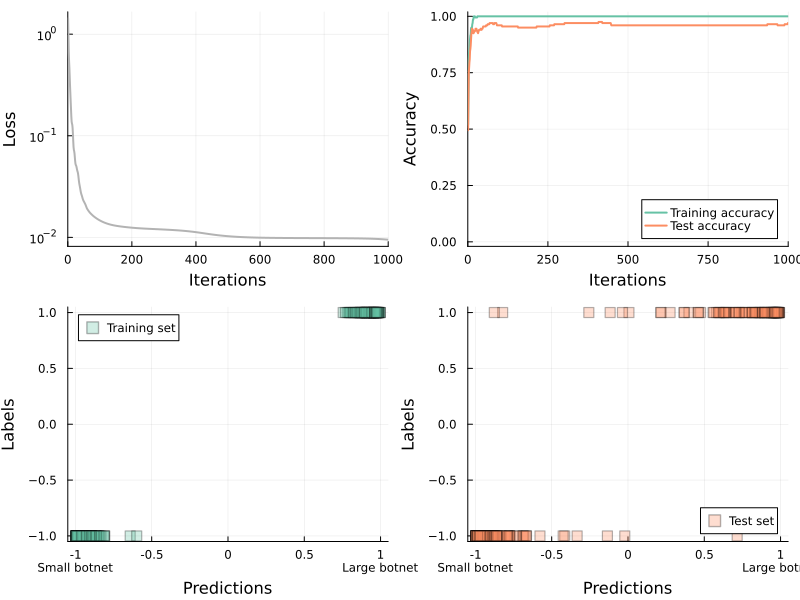

In [37]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05),xticks=(-1:0.5:1,["-1\nSmall botnet",-0.5,0,0.5,"1\nLarge botnet"]))


# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05),xticks=(-1:0.5:1,["-1\nSmall botnet",-0.5,0,0.5,"1\nLarge botnet"]))

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [19]:
savefig("n=$(N)_anomaly_detection_QCNN_invariant.pdf")

"c:\\Users\\cu234\\OneDrive - University of Exeter\\Projects\\QComp.jl\\notebooks\\n=16_anomaly_detection_QCNN_invariant.pdf"